In [3]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt


In [85]:
train = pd.read_csv("/content/train.csv" , parse_dates=['date'])

In [86]:
train['year'] = train['date'].dt.year - 2012
train['month'] = train['date'].dt.month
train['day'] = train['date'].dt.dayofyear
train['weekday'] = train['date'].dt.weekday

In [87]:
test = pd.read_csv("/content/test.csv", parse_dates=True, index_col='date')

In [90]:
test.reset_index(inplace=True)

In [91]:
test['year'] = test['date'].dt.year - 2012
test['month'] = test['date'].dt.month
test['day'] = test['date'].dt.dayofyear
test['weekday'] = test['date'].dt.weekday

In [92]:
train.shape, test.shape

((913000, 8), (45000, 8))

In [93]:
train.set_index('date', inplace=True)


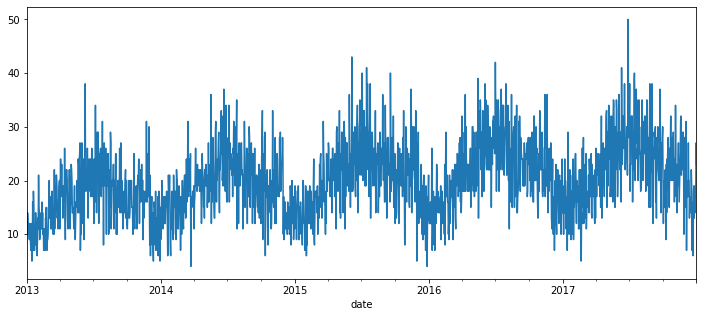

In [7]:
_1#let's plot sales for 1 item
train[(train['store']==1) & (train['item']==1)]['sales'].plot(figsize=(12,5))

We can see a seasonality in the data with sales increasing during summers to reach peak in June. The patter repeats in all the given
 5 years

In [28]:
train.describe()

,store,item,sales
count,913000.000000,913000.000000,913000.000000
mean,5.500000,25.500000,52.250287
std,2.872283,14.430878,28.801144
min,1.000000,1.000000,0.000000
25%,3.000000,13.000000,30.000000
50%,5.500000,25.500000,47.000000
75%,8.000000,38.000000,70.000000
max,10.000000,50.000000,231.000000


In [29]:
train.isna().sum()

store    0
item     0
sales    0
dtype: int64

In [8]:
#check if the data is stationary
from statsmodels.tsa.stattools import adfuller
def test_stationarity(timeseries, window = 12, cutoff = 0.01):

    #Determing rolling statistics
    rolmean = timeseries.rolling(window).mean()
    rolstd = timeseries.rolling(window).std()

    #Plot rolling statistics:
    fig = plt.figure(figsize=(12, 8))
    orig = plt.plot(timeseries, color='green',label='Original')
    mean = plt.plot(rolmean, color='red', label='Rolling Mean')
    std = plt.plot(rolstd, color='gray', label = 'Rolling Std')
    plt.legend(loc='best')
    plt.title('Rolling Mean & Standard Deviation')
    plt.show()
    
    #Perform Dickey-Fuller test:
    print('Results of Dickey-Fuller Test:')
    dftest = adfuller(timeseries, autolag='AIC', maxlag = 20 )
    dfoutput = pd.Series(dftest[0:4], index=['Test Statistic','p-value','#Lags Used','Number of Observations Used'])
    for key,value in dftest[4].items():
        dfoutput['Critical Value (%s)'%key] = value
    pvalue = dftest[1]
    if pvalue < cutoff:
        print('p-value = %.4f. The series is likely stationary.' % pvalue)
    else:
        print('p-value = %.4f. The series is likely non-stationary.' % pvalue)
    
    print(dfoutput)

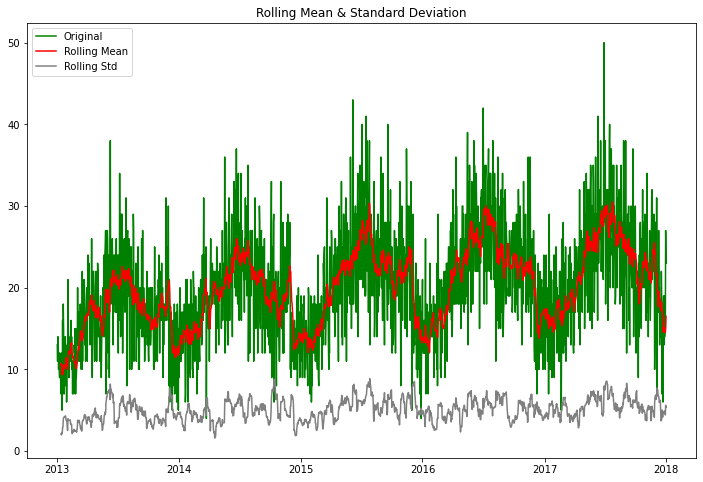

Results of Dickey-Fuller Test:
p-value = 0.0361. The series is likely non-stationary.
Test Statistic                   -2.987278
p-value                           0.036100
#Lags Used                       20.000000
Number of Observations Used    1805.000000
Critical Value (1%)              -3.433978
Critical Value (5%)              -2.863143
Critical Value (10%)             -2.567623
dtype: float64


In [96]:
item_1 = train[(train['store']==1) & (train['item']==1)]
test_stationarity(item_1['sales'])

The given data is non stationary as confirmed by Dickey Fuller Test

In [97]:
#Try making the data stationary with differencing
item_1['lag1'] = item_1['sales'] - item_1['sales'].shift(1)

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  


In [98]:
item_1.dropna(inplace=True)

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  """Entry point for launching an IPython kernel.


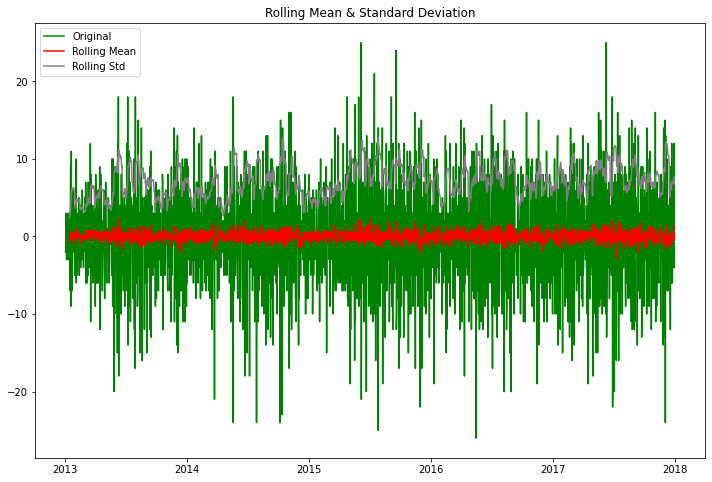

Results of Dickey-Fuller Test:
p-value = 0.0000. The series is likely stationary.
Test Statistic                -1.520810e+01
p-value                        5.705031e-28
#Lags Used                     2.000000e+01
Number of Observations Used    1.804000e+03
Critical Value (1%)           -3.433980e+00
Critical Value (5%)           -2.863143e+00
Critical Value (10%)          -2.567624e+00
dtype: float64


In [99]:
test_stationarity(item_1['lag1'])

Voila! With just 1 lag and differencing, we made the data stationary. 

In [50]:
from statsmodels.tsa.stattools import acf, pacf

/usr/local/lib/python3.6/dist-packages/statsmodels/tsa/stattools.py:541: FutureWarning: fft=True will become the default in a future version of statsmodels. To suppress this warning, explicitly set fft=False.
  warnings.warn(msg, FutureWarning)


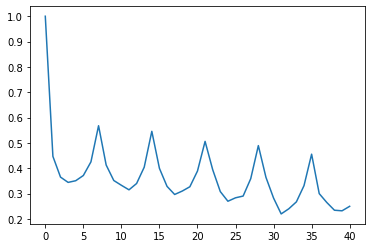

In [56]:
plt.plot(acf(item_1['sales']));

- There seems to be a strong seasonality in the data with patter occuring every 7 lags ( i.e a week)
- Since there is a sharp drop after 3 lags, we can use AR-3 model

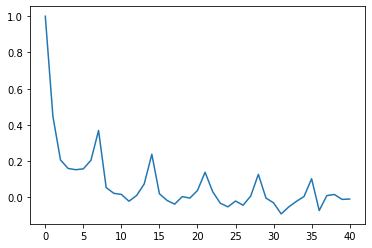

In [58]:
plt.plot(pacf(item_1['sales']));

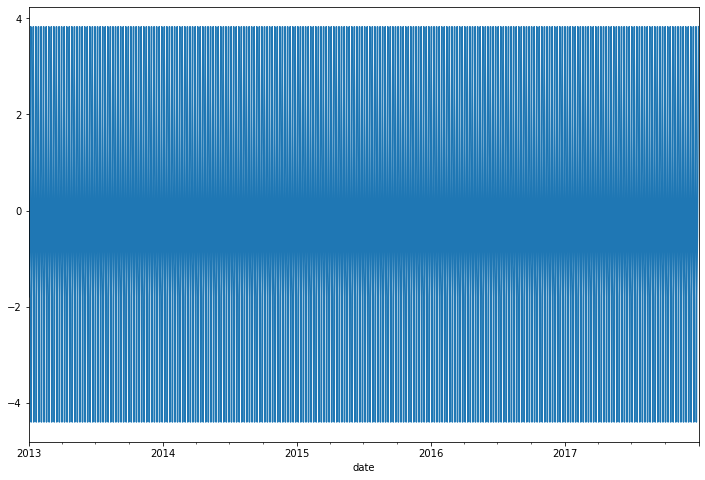

In [67]:
from statsmodels.tsa.seasonal import seasonal_decompose
seasonal_decompose(item_1['sales'],model='add').seasonal.plot(figsize=(12,8));

In [ ]:
!pip3 install pmdarima

In [1]:
from pmdarima import auto_arima

In [ ]:
step_wise = auto_arima(item_1['sales'], exogenous=item_1[['weekday']], seasonal=True, m=7, trace=True)

In [103]:
step_wise.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                                     SARIMAX Results                                     
=========================================================================================
Dep. Variable:                                 y   No. Observations:                 1825
Model:             SARIMAX(0, 1, 1)x(1, 0, 1, 7)   Log Likelihood               -5394.097
Date:                           Tue, 30 Jun 2020   AIC                          10800.194
Time:                                   21:03:54   BIC                          10833.247
Sample:                               01-02-2013   HQIC                         10812.387
                                    - 12-31-2017                                         
Covariance Type:                             opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
intercept      0.0005      0.002      0.227      0.820      -0.004       0.005
weekday        1.3011      0.067     19.391      0.000       1.170       1.433
ma.L1         -0.9013      0.011    -82.178      0.000      -0.923      -0.880
ar.S.L7        0.8315      0.099      8.372      0.000       0.637       1.026
ma.S.L7       -0.7852      0.112     -7.035      0.000      -1.004      -0.566
sigma2        21.6653      0.667     32.491      0.000      20.358      22.972
===================================================================================
Ljung-Box (Q):                       35.90   Jarque-Bera (JB):                15.95
Prob(Q):                              0.66   Prob(JB):                         0.00
Heteroskedasticity (H):               1.34   Skew:                             0.14
Prob(H) (two-sided):                  0.00   Kurtosis:                         3.37
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
"""

In [104]:
test_item_1 = test[(test['store']==1) & (test['item']==1)]


In [105]:
from statsmodels.tsa.statespace.sarimax import SARIMAX

In [123]:
model = SARIMAX(item_1['sales'][:-90], order=(0,1,1), seasonal_order=(1,0,1,7), exog=item_1[['weekday']][:-90])

/usr/local/lib/python3.6/dist-packages/statsmodels/tsa/base/tsa_model.py:162: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  % freq, ValueWarning)
/usr/local/lib/python3.6/dist-packages/statsmodels/tsa/base/tsa_model.py:162: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  % freq, ValueWarning)


In [124]:
results = model.fit()

In [125]:
predictions = results.predict(start=len(item_1['sales'])-90, end = len(item_1['sales'])-1, exog=item_1['weekday'][-90:], typ='levels', dynamic=True)

In [126]:
predictions

2017-10-03    20.195420
2017-10-04    21.525852
2017-10-05    22.844016
2017-10-06    24.920716
2017-10-07    26.409450
                ...    
2017-12-27    21.155981
2017-12-28    22.456942
2017-12-29    23.850576
2017-12-30    25.172376
2017-12-31    26.299308
Freq: D, Length: 90, dtype: float64

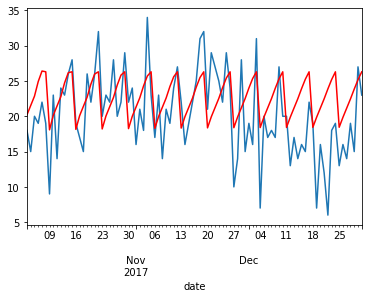

In [127]:
item_1['sales'][-90:].plot()
predictions.plot(color='red')

In [128]:
from statsmodels.tools.eval_measures import rmse

In [129]:
rmse(predictions, item_1['sales'][-90:])

5.6565983318964825